In [1]:
from si import *

Not a jupyter notebook. Not enabling notebook functions.
Welcome to JupyROOT 6.22/00
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
from g2Reader import *
from g2Fitter import *
import boost_histogram as bh

/home/jlab/miniconda3/lib/python3.7/site-packages/ROOT/_facade.py:121: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  return _orig_ihook(name, *args, **kwds)
/home/jlab/miniconda3/lib/python3.7/site-packages/luigi/scheduler.py:211: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class OrderedSet(collections.MutableSet):
/home/jlab/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
infile="/home/jlab/g-2/omega_a_KS/data/run2c_pileup_corrected_non.root"
hist="clustersAndCoincidences/uncorrected"

In [4]:
%%time

hist = g2Histogram(infile, hist)

Reading in hist clustersAndCoincidences/uncorrected from root file /home/jlab/g-2/omega_a_KS/data/run2c_pileup_corrected_non.root
<b'TH3D' b'uncorrected' 0x7fd6a274a3b0>
<class 'tuple'>
starting zip
done!
CPU times: user 13.2 s, sys: 1.7 s, total: 14.9 s
Wall time: 14.8 s


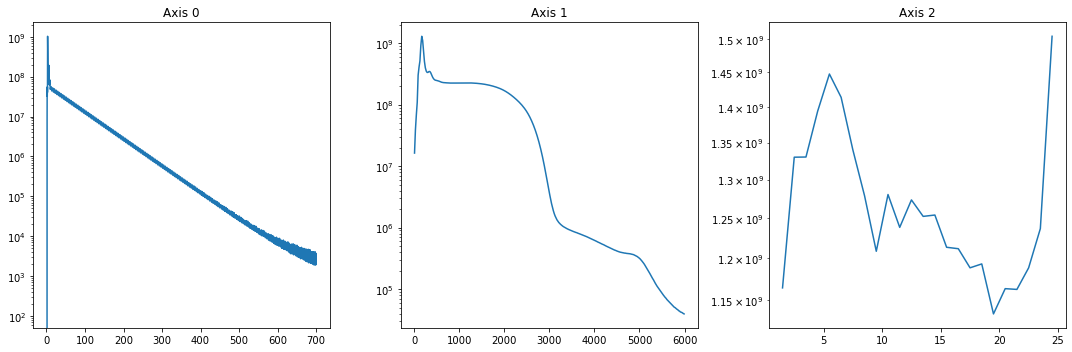

In [5]:
hist.plotprojections()
plt.tight_layout()
plt.show()

In [6]:
# @jit(nopython=True)
def compute_unscaled_double_calo(h,calo):
    '''
        Returns double_pileup(E,t) for caloNum for a given histogram
        Defined in Eq. 6.12-6.13 of Aaron's thesis
        Reimplemented from aarons precessionlib code
    '''
    
    rho = h[:,:,calo].T
    
    
    # plus term:
    # sum over rho(t, E2) * rho(t, E-E2)
    # bin i for E2, bin e_bin - 1 - i  for bin E - E2
    #
    # bins where e_bin - 1 - i <= 0 are not included,
    # those have E - E2 <= 0
    drho_pu_plus = np.empty_like(rho)
    for e_bin in range(rho.shape[0]):
        drho_pu_plus[e_bin] = np.einsum(
            'ij,ij -> j', rho[:e_bin, :], rho[:e_bin, :][::-1])

    # minus term:
    # sum over rows of rho(t, E) * rho(t, E2)
    # has a factor of two
    drho_pu_minus = -2 * rho * rho.sum(axis=0)

    return drho_pu_plus.T, drho_pu_minus.T

# @jit(nopython=True)
def compute_unscaled_double(h):
    '''
        Correct the spectrum of an Energy vs. Time vs. CaloNum histogram using Aarons method
    '''
    
#     double_pileup = np.zeros_like(h)
    rho_double_calo_pos = np.zeros_like(h)
    rho_double_calo_neg = np.zeros_like(h)
    
    for calo in range(h.shape[2]):
        print("Starting calo", calo+1)
        rho_double_calo_pos[:,:,calo], rho_double_calo_neg[:,:,calo] = compute_unscaled_double_calo(h,calo)
        
    double_pileup = (rho_double_calo_pos + rho_double_calo_neg)
        
    return double_pileup, rho_double_calo_pos, rho_double_calo_neg

def compute_triple_pileup_calo(h, double_plus_calos, calo):
    
    rho = h[:,:,calo].T
    double_plus = double_plus_calos[:,:,calo].T
    
    rho_ints = rho.sum(axis=0)

    # distribution of sum of three positron energies
    trip_sum = np.empty_like(rho)
    for e_bin in range(rho.shape[0]):
        trip_sum[e_bin] = np.einsum(
            'ij,ij -> j', double_plus[:e_bin, :], rho[:e_bin, :][::-1])

    # correct for positive double pileup that was part of a triple
    trip_term_two = -3 * double_plus * rho_ints

    # correct for negative double pileup that was part of a triple
    trip_term_three = 3 * rho * np.power(rho_ints, 2)

    return [trip_sum.T, trip_term_two.T, trip_term_three.T]
    
def compute_triple_pileup(h, double_plus):
    '''builds the non-normalized triple pileup contributions
    returns: tripleSum, doubleCorrection, singleCorrection
    '''
    
    triple_pileup = np.zeros_like(h)
    
    for calo in range(h.shape[2]):
        print("Starting calo", calo+1)
        rho_triple = compute_triple_pileup_calo(h, double_plus ,calo)
        
        triple_pileup[:,:,calo] = sum(rho_triple)
        
    return triple_pileup

In [7]:
%%time 

rho_double = compute_unscaled_double_calo(hist.h.view().value, 0)

CPU times: user 422 ms, sys: 9.99 ms, total: 432 ms
Wall time: 427 ms


In [8]:
%%time

h_double = compute_unscaled_double(hist.h.view().value)

Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24
CPU times: user 9.65 s, sys: 240 ms, total: 9.89 s
Wall time: 9.8 s


In [9]:
hist.h.axes[0].edges[-1]

700.0

/home/jlab/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  


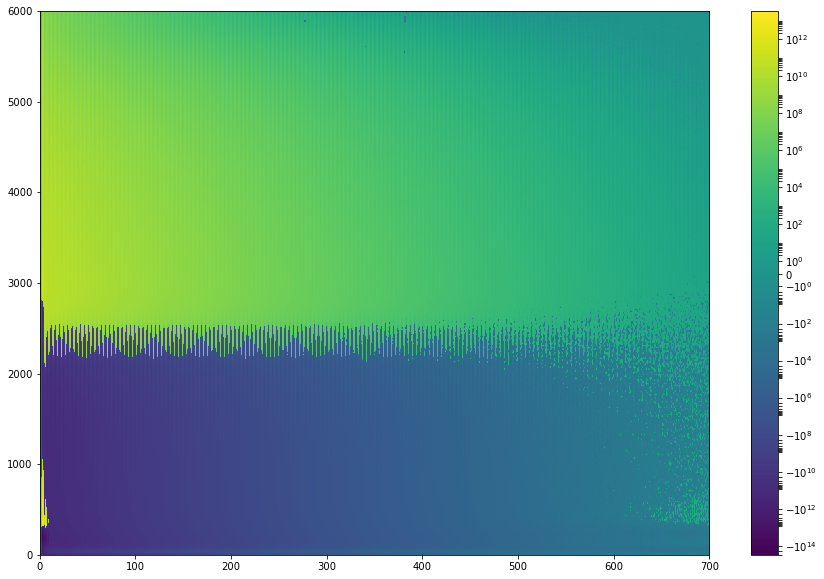

In [10]:
fig,ax = plt.subplots(figsize=(15,10))
plt.imshow(h_double[0][:,:,0].T,aspect='auto',norm=matplotlib.colors.SymLogNorm(1),origin='lower',
          extent=(hist.h.axes[0].edges[0], hist.h.axes[0].edges[-1], hist.h.axes[1].edges[0], hist.h.axes[1].edges[-1]) )
plt.colorbar()
plt.show()

In [11]:
%%time

h_triple = compute_triple_pileup_calo(hist.h.view().value, h_double[1], 0)

CPU times: user 358 ms, sys: 9.51 ms, total: 367 ms
Wall time: 362 ms


In [12]:
%%time

h_triple = compute_triple_pileup(hist.h.view().value, h_double[1])

Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24
CPU times: user 8.54 s, sys: 166 ms, total: 8.71 s
Wall time: 8.63 s


In [13]:
h_triple.shape

(4692, 300, 24)

/home/jlab/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  


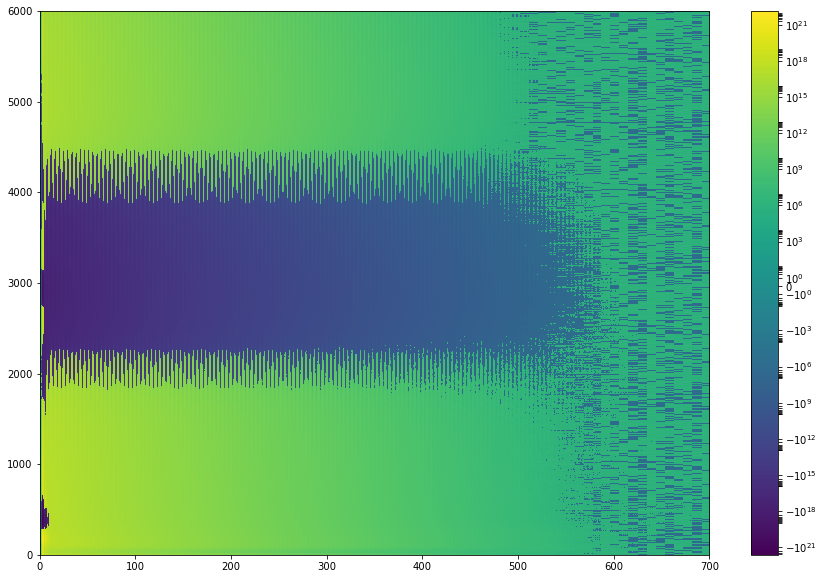

In [14]:
fig,ax = plt.subplots(figsize=(15,10))
plt.imshow(h_triple[:,:,0].T,aspect='auto',norm=matplotlib.colors.SymLogNorm(1),origin='lower',
          extent=(hist.h.axes[0].edges[0], hist.h.axes[0].edges[-1], hist.h.axes[1].edges[0], hist.h.axes[1].edges[-1]) )
plt.colorbar()
plt.show()

In [15]:
h = hist.h
double_pileup = h_double[0]
triple_pileup = h_triple
energyRange = [175, 300]
timeRange = [167, 4021]
calo = 0

In [16]:
h.project(1).shape

(300,)

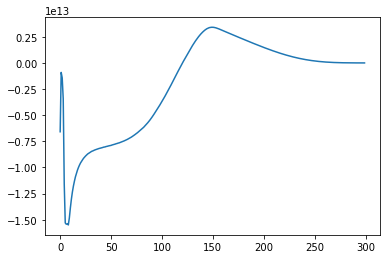

In [17]:
plt.plot(double_pileup[timeRange[0]:,:energyRange[1],calo].sum(axis=0))

In [18]:
#     fig,axs = plt.subplots(2,2,figsize=(10,8))
#     ax = axs.ravel()
#     plt.sca(ax[0])
#     plt.title("Unscaled Time Spectrum")
#     print(energyRange)
#     print(timeRange)
#     plt.plot(times, h[timeRange[0]:timeRange[1],energyRange[0]:energyRange[1],calo].sum(axis=1),label="time spectrum" )
#     plt.plot(times, double_pileup[timeRange[0]:timeRange[1],energyRange[0]:energyRange[1],calo].sum(axis=1), label='double pileup')
#     plt.plot(times, triple_pileup[timeRange[0]:timeRange[1],energyRange[0]:energyRange[1],calo].sum(axis=1), label='triple pileup')
#     plt.legend()
    
# #     plt.sca(ax[1])
# #     plt.plot( h[timeRange[0]:timeRange[1],energyRange[0]:energyRange[1],calo].sum(axis=0),label="time spectrum" )
# #     plt.plot( double_pileup[timeRange[0]:timeRange[1],energyRange[0]:energyRange[1],calo].sum(axis=0), label='double pileup')
# #     plt.plot( triple_pileup[timeRange[0]:timeRange[1],energyRange[0]:energyRange[1],calo].sum(axis=0), label='triple pileup')
    
#     plt.sca(ax[1])
#     plt.title("Unscaled Energy Spectrum")
#     plt.plot( energies, h[timeRange[0]:timeRange[1],:,calo].sum(axis=0),label="time spectrum" )
#     plt.plot( energies, double_pileup[timeRange[0]:timeRange[1],:,calo].sum(axis=0), label='double pileup')
#     plt.plot( energies, triple_pileup[timeRange[0]:timeRange[1],:,calo].sum(axis=0), label='triple pileup')

In [19]:
def pileup_fit(x,p):
    double_scale = p[0]
    triple_scale = p[1]
    
#     print(x.shape)
#     print(p)
    thisdouble = double_pileup[timeRange[0]:timeRange[1],energyRange[0]:energyRange[1],calo].sum(axis=0)
#     print(thisdouble.shape)#, thisdouble)
    thistriple = triple_pileup[timeRange[0]:timeRange[1],energyRange[0]:energyRange[1],calo].sum(axis=0)
#     print(thistriple.shape)#, thisdouble)
    
    ret_val =  (x
            - double_scale * thisdouble
            - triple_scale * thistriple)
#     print(ret_val)
    return ret_val

def fit_pileup_calo(hist, double_pileup, triple_pileup, energyRange, timeRange, calo):
    '''
        Fit the non-physical tail of the histogram to a limear combination of the double and triple pileup spectra
    '''
    
    h = hist.h.view().value
    times = hist.h.axes[0].centers[timeRange[0]:timeRange[1]]
#     print(times)
    energies = hist.h.axes[1].centers#[energyRange[0]:energyRange[1]]
#     print(energies)
    
    
    fig, ax = plt.subplots(figsize=(15,8))


    
    to_fit = hist.h[timeRange[0]:timeRange[1],energyRange[0]:energyRange[1],calo].project(1)
    print(to_fit.shape)
    
    fit = g2Fitter("custom","LeastSquares","dei",to_fit, [0.0001,0.000000001], custom_func = pileup_fit, 
                   do_iterative_fit=False, fit_list=[1], final_unlimited_fit=False, 
#                    useError=False
#                    fit_limits=[None, [0,0]]
                   fit_limits=[None, [0,0]]
                  )
    fit.do_fit()
#     plt.sca(ax[3])
    plt.title("Scaled Energy Spectrum")
    plt.xlabel("Energy [MeV]")
    plt.ylabel("Counts")
    
    scaled_doubles = fit.values[0]*double_pileup[timeRange[0]:timeRange[1],:,calo].sum(axis=0)
    scaled_triples = fit.values[1]*triple_pileup[timeRange[0]:timeRange[1],:,calo].sum(axis=0)
    
    plt.plot( energies, h[timeRange[0]:timeRange[1],:,calo].sum(axis=0),label="time spectrum" )
    plt.plot( energies, 1*scaled_doubles, label='double pileup')
    plt.plot( energies, 1*scaled_triples, label='triple pileup')
    plt.plot( energies, 1*scaled_triples + scaled_doubles, label='double+triple pileup')
    
    plt.plot(energies,  h[timeRange[0]:timeRange[1],:,calo].sum(axis=0) - scaled_doubles - scaled_triples, color="xkcd:grey",
            label="Pileup Subtracted")
    
    fit.drawFitResult(ax, xrange=None, scaleFactor=1, color='red', label="Pileup Spectrum")
    
    plt.plot([0,6000],[0,0],":", color="xkcd:light brown")
    
    return(fig,ax,fit)
    

(125,)
Initializing fit!
Starting fit...
<iminuit._libiminuit.Minuit object at 0x55e7ad220390> <iminuit.cost.LeastSquares object at 0x7fd6b0e1edd0>
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |  100e-6   |   1e-6    |            |            |         |         |       |
| 1 | p1   |     0     |  0.01e-9  |            |            |         |         |  yes  |
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |  52.8e-9  |  0.8e-9 

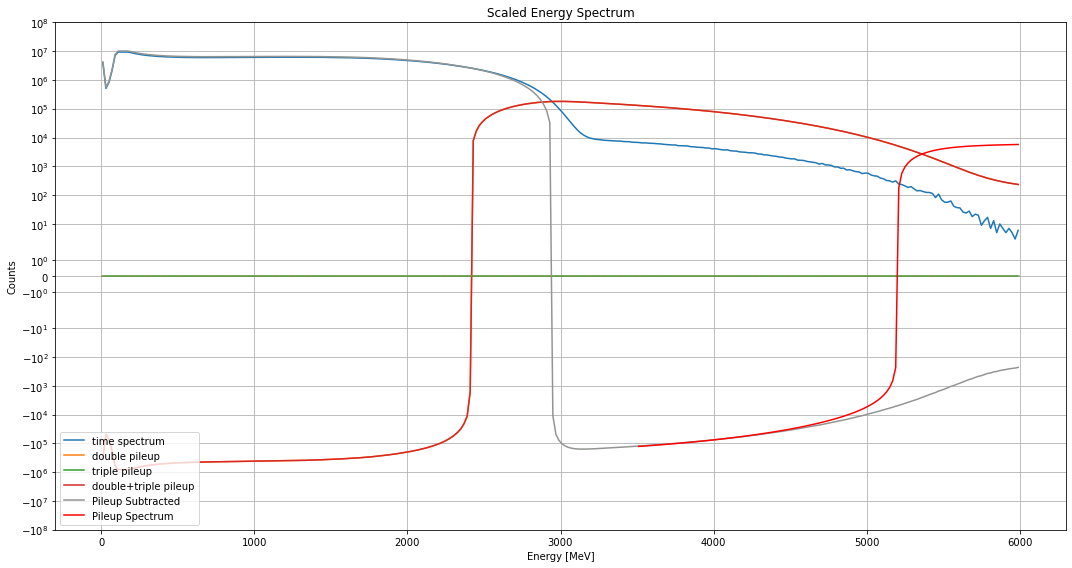

In [20]:
fig,ax,fit = fit_pileup_calo(hist, h_double[0], h_triple, 
                             [hist.h.axes[1].index(3500),hist.h.axes[1].index(6000)], 
                             [hist.h.axes[0].index(25.),hist.h.axes[0].index(600)],
                             0)
# ax[0].set_xlim(30,70)
# for axi in ax:
#     plt.sca(axi)
plt.yscale("symlog")
plt.grid()
plt.tight_layout()
plt.legend(loc=3)
plt.ylim(-1*10**(8), 10**8)
plt.show()

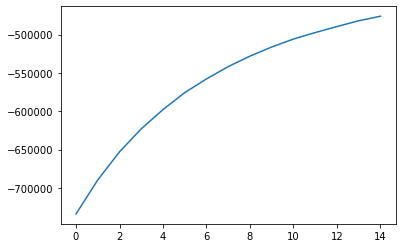

In [21]:
plt.plot(fit.values[0]*double_pileup[timeRange[0]:timeRange[1],10:25,calo].sum(axis=0))

In [22]:
np.sum(fit.residualsInRange)

4795320.702351327

(<Figure size 1080x576 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fd5dd6bcf50>])

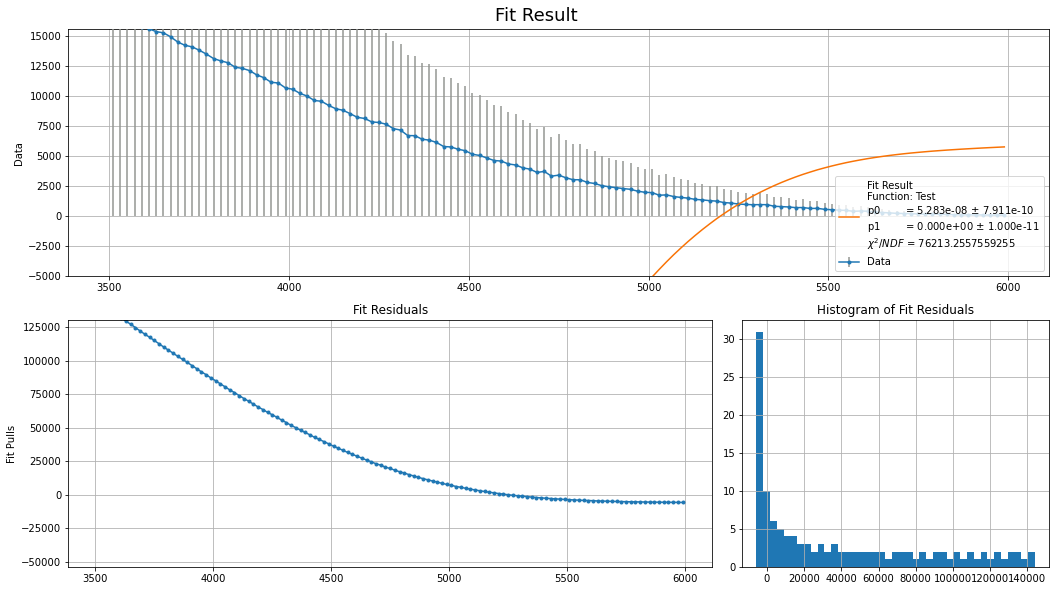

In [23]:
fit.draw(scaleFactor=1, 
#          yrange=[[-10,25000], [-20000,20000]], 
         do_pulls=False)